In [1]:
import pandas as pd
import caspailleur as csp
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
blog_features = pd.read_csv('features_aggregated.csv', sep="\t")
blog_features.head(5)

,Unnamed: 0,author_id,occupation_Accounting,occupation_Advertising,occupation_Agriculture,occupation_Architecture,occupation_Arts,occupation_Automotive,occupation_Banking,occupation_Biotech,...,"irony_(-0.001, 0.2]","irony_(0.2, 0.4]","irony_(0.4, 0.6]","irony_(0.6, 0.8]","irony_(0.8, 1.0]","sarcasm_(-0.001, 0.2]","sarcasm_(0.2, 0.4]","sarcasm_(0.4, 0.6]","sarcasm_(0.6, 0.8]","sarcasm_(0.8, 1.0]"
0,0,5114,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1,7596,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,2,8349,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,3,9289,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,4,9470,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [3]:
print(blog_features.shape)

(18983, 134)


In [4]:
binary_features = blog_features.drop(columns=['Unnamed: 0', 'author_id'])
binary_features.head()

,occupation_Accounting,occupation_Advertising,occupation_Agriculture,occupation_Architecture,occupation_Arts,occupation_Automotive,occupation_Banking,occupation_Biotech,occupation_BusinessServices,occupation_Chemicals,...,"irony_(-0.001, 0.2]","irony_(0.2, 0.4]","irony_(0.4, 0.6]","irony_(0.6, 0.8]","irony_(0.8, 1.0]","sarcasm_(-0.001, 0.2]","sarcasm_(0.2, 0.4]","sarcasm_(0.4, 0.6]","sarcasm_(0.6, 0.8]","sarcasm_(0.8, 1.0]"
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [5]:
def verbose(barray: 'frozenbitarray', names=binary_features.columns):
  "Take bitarray and return a comma-separated names of representing indices of 1s"
  return ','.join(names[list(barray.itersearch(True))])

In [6]:
# Step 0. Preprocess the data
itemsets_ba = csp.np2bas(binary_features.values)
crosses_per_columns = list(csp.base_functions.bas2isets(csp.np2bas(binary_features.values.T)))

# Step 1. Compute all extents in intents
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp = 0.03)
extent_intent_map = {
    csp.base_functions.extension(intent.itersearch(True), crosses_per_columns): intent
    for intent in intents_ba
}
extents = sorted(extent_intent_map, key=lambda ext: len(ext))
extents_ba = list(csp.base_functions.isets2bas(extents, len(itemsets_ba)))


In [7]:
print('Number of intents: ', len(intents_ba))

Number of intents:  10951


In [8]:

# Step 2. Find the best concepts (e.g. with the biggest stability)
n_best = 30

stabilities = list(csp.indices.delta_stability_index(extents_ba))
best_indices = list(np.argsort(stabilities)[-n_best:])
best_indices = sorted(best_indices, key=lambda i: extent_intent_map[extents[i]].count())
best_extents = [extents[i] for i in best_indices]
best_intents = [extent_intent_map[extents[i]] for i in best_indices]
best_intents_plus_bottom = best_intents + intents_ba[-1:]

# Step 3. Compute reduced intents that would make nice node titles
children_ordering_with_bottom = csp.sort_intents_inclusion(best_intents_plus_bottom)
children_ordering = [children[:-1] for children in children_ordering_with_bottom[:-1]]
parents_ordering = csp.inverse_order(children_ordering)

reduced_intents = []
for intent, parents in zip(best_intents, parents_ordering):
  reduced_intent = intent
  for parent_i in parents.itersearch(True):
    reduced_intent = reduced_intent & ~best_intents[parent_i]
  reduced_intents.append(reduced_intent)

reduced_intents_verb = [verbose(intent) for intent in reduced_intents]

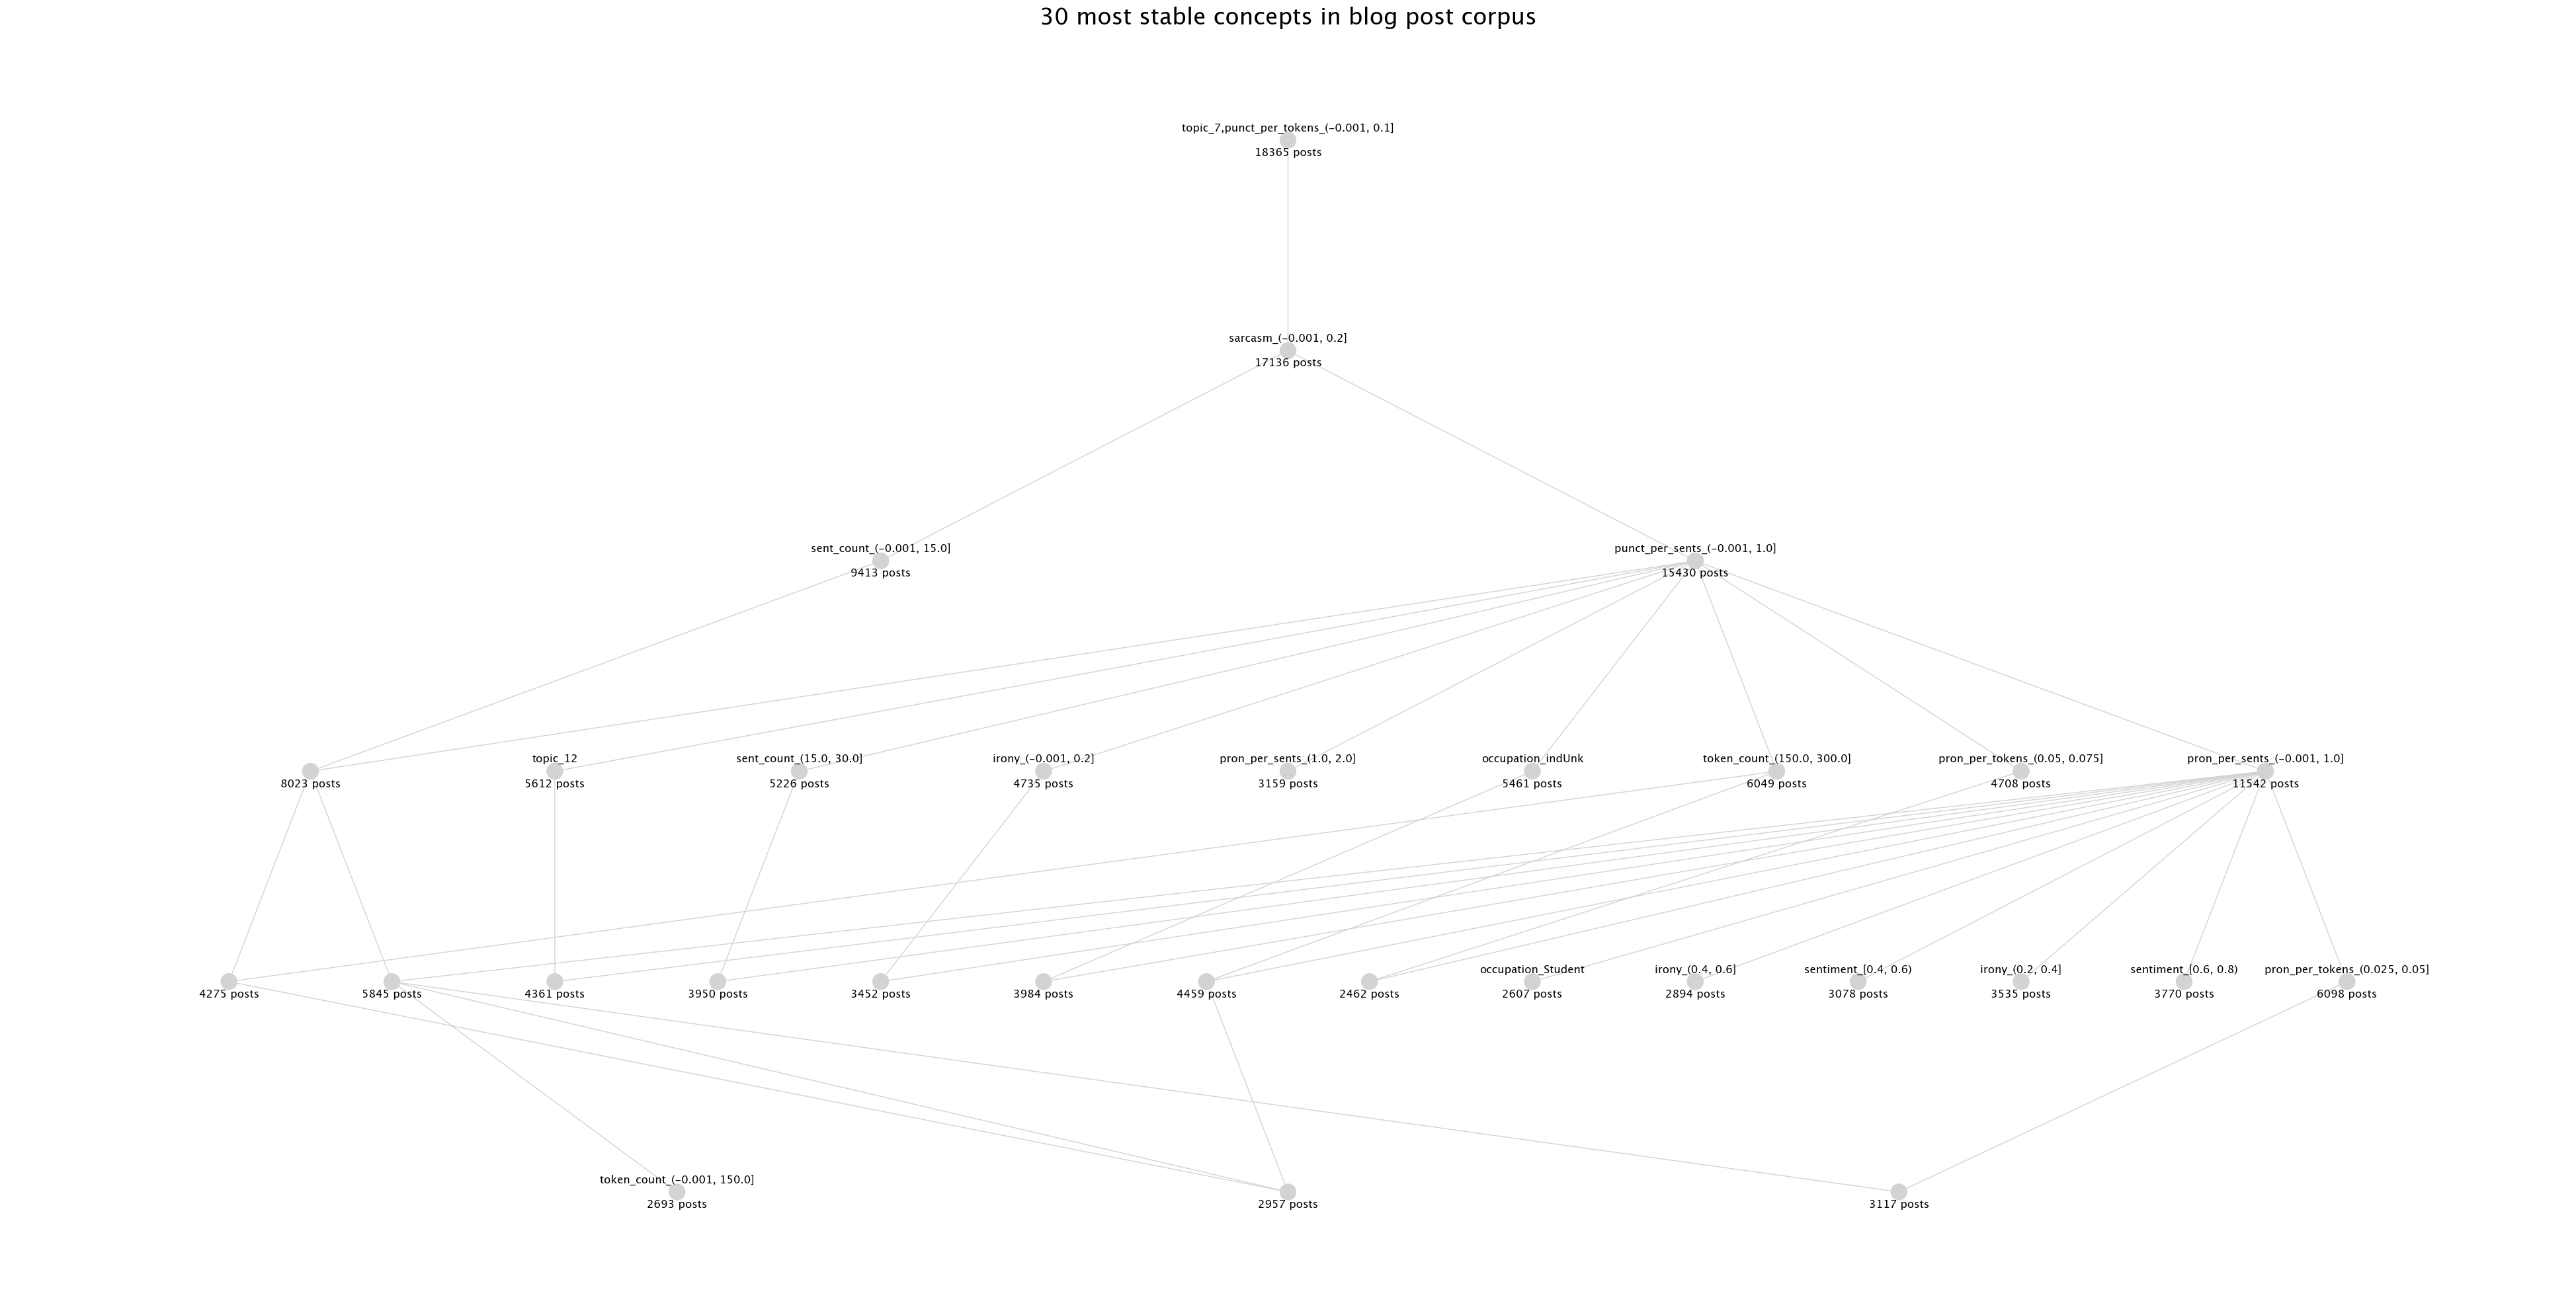

In [12]:
from fcapy.poset import POSet
from fcapy.visualizer import LineVizNx
poset = POSet(best_extents)

fig, ax = plt.subplots(figsize=(50,25))

viz = LineVizNx()
viz.draw_poset(
    poset, ax=ax,
    node_label_func = lambda el_i, P: f"{reduced_intents_verb[el_i]}\n\n{len(best_extents[el_i])} posts",
)
plt.title(f"{n_best} most stable concepts in blog post corpus", size=25)

plt.show()

In [13]:
keys_dict = csp.list_keys(intents_ba)

# If no objects are described by all attributes,
# then drop the keys of bottom intent from computations
if not any(itemset_ba.all() for itemset_ba in itemsets_ba):
  keys_dict = {key: i for key, i in keys_dict.items() if not intents_ba[i].all()}

pseudo_intents = csp.list_pseudo_intents_via_keys(keys_dict.items(), intents_ba, use_tqdm=True, n_keys=len(keys_dict))
print(len(pseudo_intents))

Iterate p.intent candidates:   0%|          | 0/10950 [00:00<?, ?it/s]

197


In [14]:
for i, (pintent, intent_i) in enumerate(pseudo_intents):
  pintent_verb = verbose(pintent)
  conclusion = intents_ba[intent_i] & ~pintent
  conclusion_verb = verbose(conclusion)
  if 'zodiac' in pintent_verb or 'zodiac' in conclusion_verb:
    print(f"{i}: {pintent_verb} => {conclusion_verb}")

14: zodiac_sign_Virgo,pron_per_tokens_(0.025, 0.05] => topic_7
15: zodiac_sign_Scorpio,pron_per_tokens_(0.025, 0.05] => topic_7
16: zodiac_sign_Sagittarius,sent_count_(-0.001, 15.0] => topic_7
17: zodiac_sign_Sagittarius,token_count_(150.0, 300.0] => topic_7
18: zodiac_sign_Pisces,token_count_(150.0, 300.0] => topic_7
19: zodiac_sign_Libra,pron_per_tokens_(0.05, 0.075] => topic_7
20: zodiac_sign_Leo,pron_per_tokens_(0.025, 0.05] => topic_7
21: zodiac_sign_Leo,token_count_(150.0, 300.0] => topic_7
22: zodiac_sign_Cancer,token_count_(150.0, 300.0] => topic_7
23: zodiac_sign_Aries,token_count_(150.0, 300.0] => topic_7
24: zodiac_sign_Aquarius,pron_per_tokens_(0.025, 0.05] => topic_7
31: topic_12,zodiac_sign_Cancer => topic_7
40: occupation_indUnk,zodiac_sign_Cancer => topic_7
90: zodiac_sign_Virgo,token_count_(150.0, 300.0],sarcasm_(-0.001, 0.2] => topic_7
91: zodiac_sign_Virgo,token_count_(150.0, 300.0],punct_per_tokens_(-0.001, 0.1] => topic_7
92: zodiac_sign_Virgo,token_count_(150.0, 3

In [ ]:
parents_ordering, parents_ordering_trans = csp.sort_intents_inclusion(intents_ba, use_tqdm=True, return_transitive_order=True)

In [19]:
# Support of a concept is the cardinality of its extent
intent_extent_support = []
for intent in intents_ba:
    extent = csp.base_functions.extension(intent.itersearch(True), crosses_per_columns)
    intent_extent_support.append((intent, extent, len(extent)))

# Selecting the intents with high support
min_supp_thold = 1000
best_intents = [(intent, extent, s) for intent, extent, s in intent_extent_support if s >= min_supp_thold]
print(f"# intents: {len(intents_ba)},\t # intents with support >= {min_supp_thold}: {len(best_intents)}")

# intents: 10951,	 # intents with support >= 500: 10950


In [21]:
keys_dict = csp.list_keys(intents_ba)
keys_dict = {key: intent_i for key, intent_i in keys_dict.items() if not intents_ba[intent_i].all()}  # Filter out keys corresponding to the bottom concept

proper_premises = list(csp.iter_proper_premises_via_keys(intents_ba, keys_dict))
print('# proper premises', len(proper_premises))

# proper premises 197


In [23]:
for premise, intent_i in proper_premises:
  conclusion = intents_ba[intent_i] & ~premise
  premise_verb = verbose(premise)
  conclusion_verb = verbose(conclusion)
  if 'zodiac' in premise_verb or 'zodiac' in conclusion_verb:
      print(premise_verb, '=>', conclusion_verb)

occupation_indUnk,zodiac_sign_Cancer => topic_7
topic_12,zodiac_sign_Cancer => topic_7
zodiac_sign_Aquarius,pron_per_tokens_(0.025, 0.05] => topic_7
zodiac_sign_Aries,token_count_(150.0, 300.0] => topic_7
zodiac_sign_Cancer,token_count_(150.0, 300.0] => topic_7
zodiac_sign_Leo,token_count_(150.0, 300.0] => topic_7
zodiac_sign_Leo,pron_per_tokens_(0.025, 0.05] => topic_7
zodiac_sign_Libra,pron_per_tokens_(0.05, 0.075] => topic_7
zodiac_sign_Pisces,token_count_(150.0, 300.0] => topic_7
zodiac_sign_Sagittarius,token_count_(150.0, 300.0] => topic_7
zodiac_sign_Sagittarius,sent_count_(-0.001, 15.0] => topic_7
zodiac_sign_Scorpio,pron_per_tokens_(0.025, 0.05] => topic_7
zodiac_sign_Virgo,pron_per_tokens_(0.025, 0.05] => topic_7
zodiac_sign_Gemini,pron_per_sents_(-0.001, 1.0],pron_per_tokens_(0.025, 0.05] => topic_7
zodiac_sign_Gemini,pron_per_tokens_(0.025, 0.05],punct_per_sents_(-0.001, 1.0] => punct_per_tokens_(-0.001, 0.1]
zodiac_sign_Libra,token_count_(150.0, 300.0],punct_per_sents_(-0.0

In [ ]:
len(implications_with_zodiac)

In [ ]:
zodiac_implications_df = pd.DataFrame(implications_with_zodiac, columns=['Intents', 'Extents', 'Support'])

In [ ]:
zodiac_implications_df

In [ ]:
zodiac_implications_df.to_csv('zodiac_implications_df.csv')